In [1]:
import numpy as np 
import pandas as pd 
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel('Online Retail.xlsx')

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df = df.dropna(subset=['CustomerID'])

In [6]:
# Check duplicates
df.duplicated().sum()

5225

In [7]:
df = df.drop_duplicates()

In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df.describe()

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


# Cohort analysis

In [10]:
def get_month(x): 
    return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
df['CohortGroup'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortGroup
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [11]:
def get_month_int(data, column):
    year = data[column].dt.year
    month = data[column].dt.month
    return year, month

invoice_year, invoice_month = get_month_int(df, 'InvoiceMonth')
cohort_year, cohort_month = get_month_int(df, 'CohortGroup')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df['CohortStage'] = year_diff * 12 + month_diff + 1

## Monthly active customers for each cohort

In [12]:
# Count monthly active customers from each cohort
grouping = df.groupby(['CohortGroup', 'CohortStage'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

In [13]:
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortGroup',columns='CohortStage',values='CustomerID')
cohort_counts

CohortStage,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortGroup,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Retention Rate of each cohort

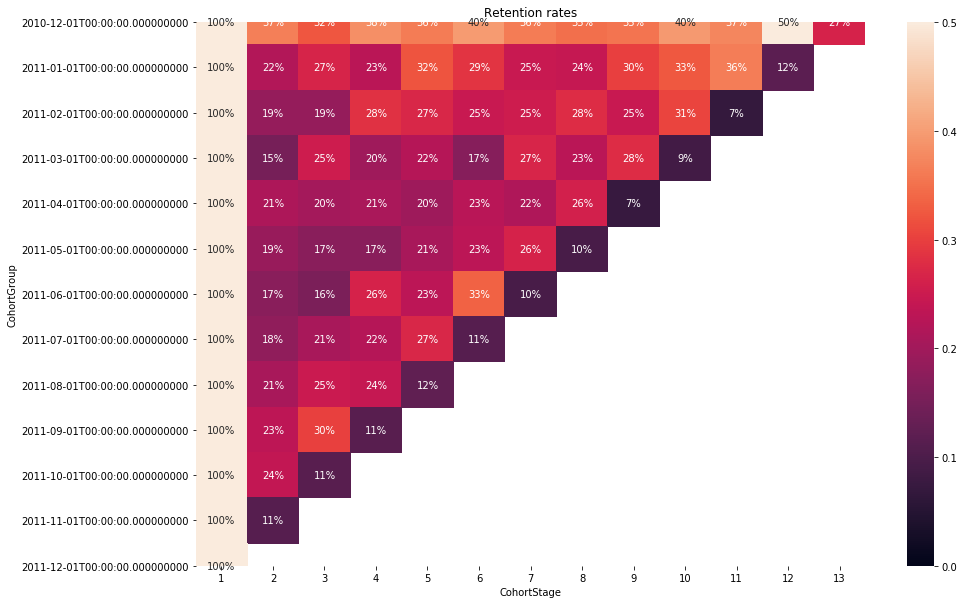

In [14]:
cohort_size = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_size, axis=0)
retention.round(3) * 100

#Heatmap visualization
plt.figure(figsize=(15, 10))
plt.title('Retention rates')
sns.heatmap(data=retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=0.5)
plt.show()

The retention rate for new cohort groups were generally lower than that of the older group. If the first cohort users were the first batch of users for the product, this would make sense because typically the users who join the launch could be the ones with the most engagement and retention given their bias towards being the first adopters. If it's not the case, I guessed there might be some product changes in the past few months which led to a decrease followed by an increase in the retention rate of different cohort groups.

Within each groups, user's retention rate increase they use the product for a longer period of time, which is quite understandable.

## Average quantity for each cohort

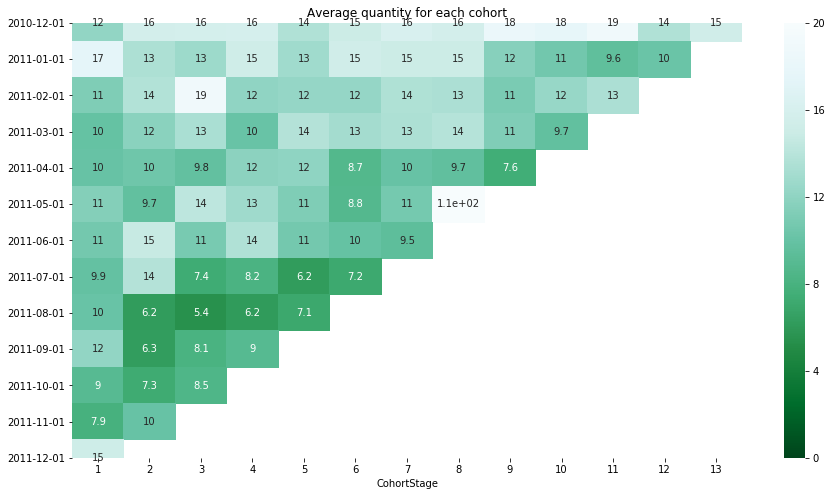

In [15]:
grouping = df.groupby(['CohortGroup', 'CohortStage'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortGroup',columns='CohortStage',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity,annot = True,vmin = 0.0,vmax =20,cmap="BuGn_r")
plt.show()

The purchasing quantity for new cohort was generally lower than that of the old cohort. Also within each cohort, user's purchasing quantity decreased as they used the product. This might be a problem that we need to do more investigation and figure out its reason.